In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import scipy as sp
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
import lightgbm as lgb

from matplotlib import rc          # for Mac
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 경고 문구 off
import warnings
warnings.filterwarnings('ignore')

/Users/jwmoon/miniforge3/envs/tf25/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1. 데이터 전처리

### (1) 데이터 불러오기

In [2]:
train_data = pd.read_csv('2019houseprice/train.csv')
test_data = pd.read_csv('2019houseprice/test.csv')
print(train_data.shape)
print(test_data.shape)

(15035, 21)
(6555, 20)


In [3]:
train_data.head(1)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650


In [4]:
test_data.head(1)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15208,20140512T000000,4,4.5,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930


### (2) 데이터 살펴보기

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

### (3) 유사도가 높은 순서대로 계층적으로 클러스터(Hierarchical Clustering) 형성

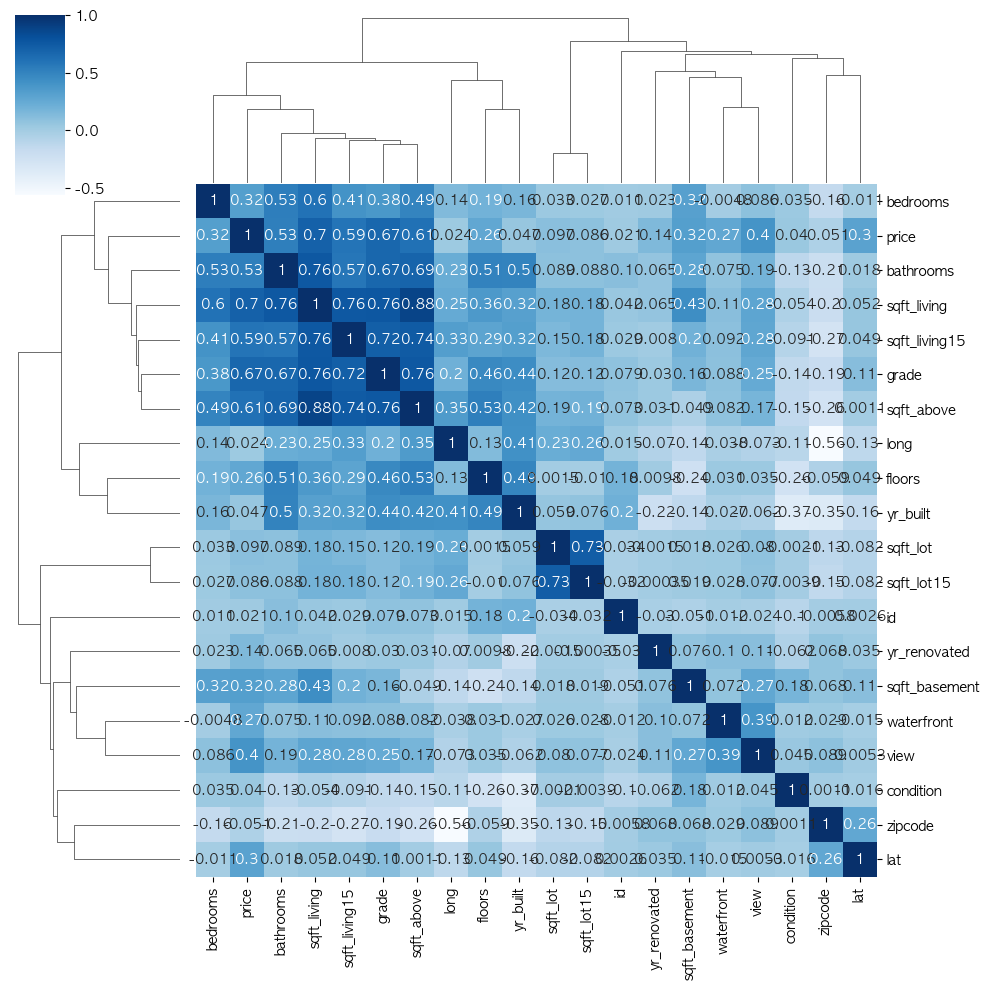

In [5]:
sns.clustermap(train_data.corr(), annot=True, cmap='Blues')
plt.show()

### (4) price(target)와 correlation이 높은 Top 10

1. sqft_living(0.7) : 근처 15 가구의 주거 공간, 평방 피트
2. grade(0.67) : King County grading 시스템 기준으로 매긴 집의 등급
3. sqft_above(0.61) : 지하실을 제외한 평방 피트
4. sqft_living15(0.59) : 근처 15 가구의 주거 공간, 평방 피트
5. bathrooms(0.53) : bathrooms : 침실당 화장실 개수
6. view(0.4) : 집이 얼마나 좋아 보이는지의 정도
7. sqft_basement(0.32) : 지하실의 평방 피트
8. bedrooms(0.32) : 침실의 수
9. lat(0.3) : 위도
10. waterfront(0.27) : 집의 전방에 강이 흐르는지 유무

In [6]:
del train_data['sqft_lot']
del train_data['floors']
del train_data['condition']
del train_data['yr_built']
del train_data['yr_renovated']
del train_data['zipcode']
del train_data['long']
del train_data['sqft_lot15']

del test_data['sqft_lot']
del test_data['floors']
del test_data['condition']
del test_data['yr_built']
del test_data['yr_renovated']
del test_data['zipcode']
del test_data['long']
del test_data['sqft_lot15']

y = train_data['price']
del train_data['price']

### (5) 학습 데이터와 테스트 데이터 합치기

In [7]:
train_data_len = len(train_data)
data = pd.concat((train_data, test_data), axis=0)
print(len(data))

21590


In [8]:
train_data_id = data['id'][train_data_len:]  # train_data_id : 15035개
del data['id']

# date 컬럼은 apply 함수로 필요한 부분만 자르기
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)  # 201410

data.head(1)

,date,bedrooms,bathrooms,sqft_living,waterfront,view,grade,sqft_above,sqft_basement,lat,sqft_living15
0,201410,3,1.0,1180,0,0,7,1180,0,47.5112,1340


### (6) 데이터 결측치 처리

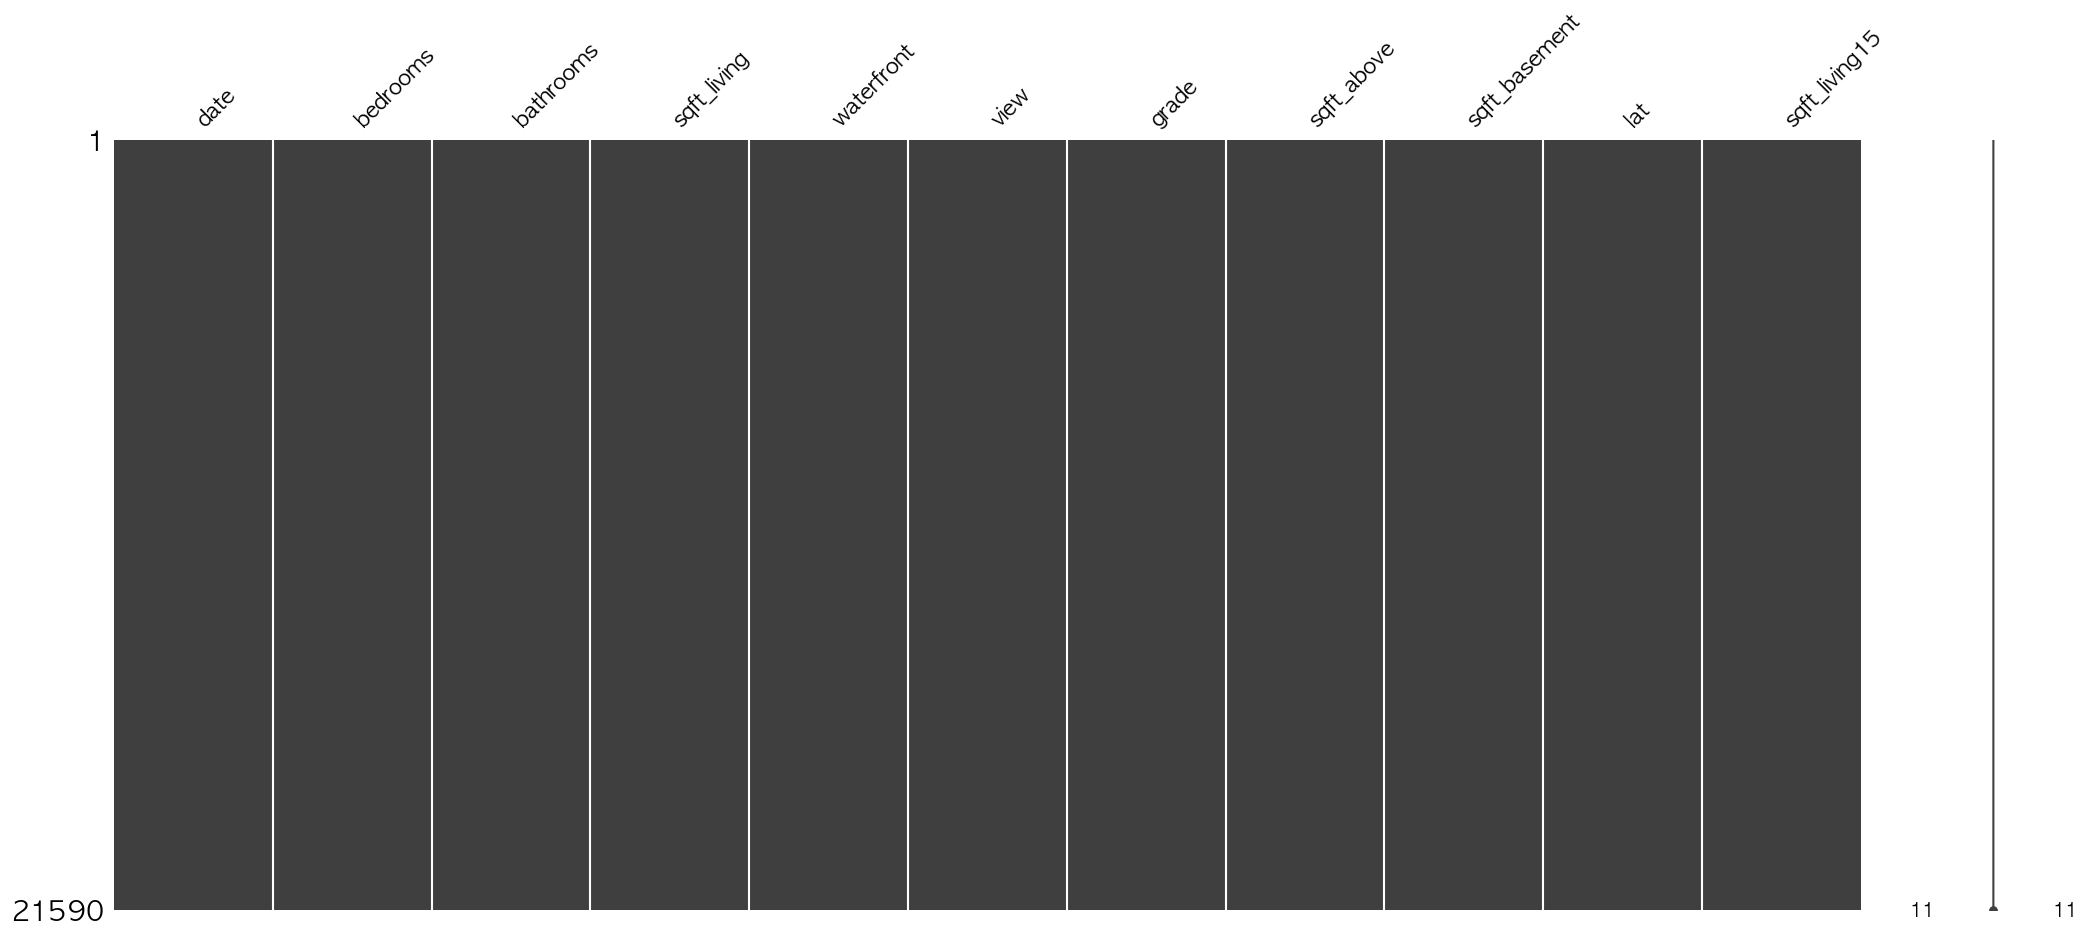

In [9]:
msno.matrix(data);

In [10]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
waterfront : 0
view : 0
grade : 0
sqft_above : 0
sqft_basement : 0
lat : 0
sqft_living15 : 0


### (7) 전체 데이터들의 분포 확인

kdeplot은 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수

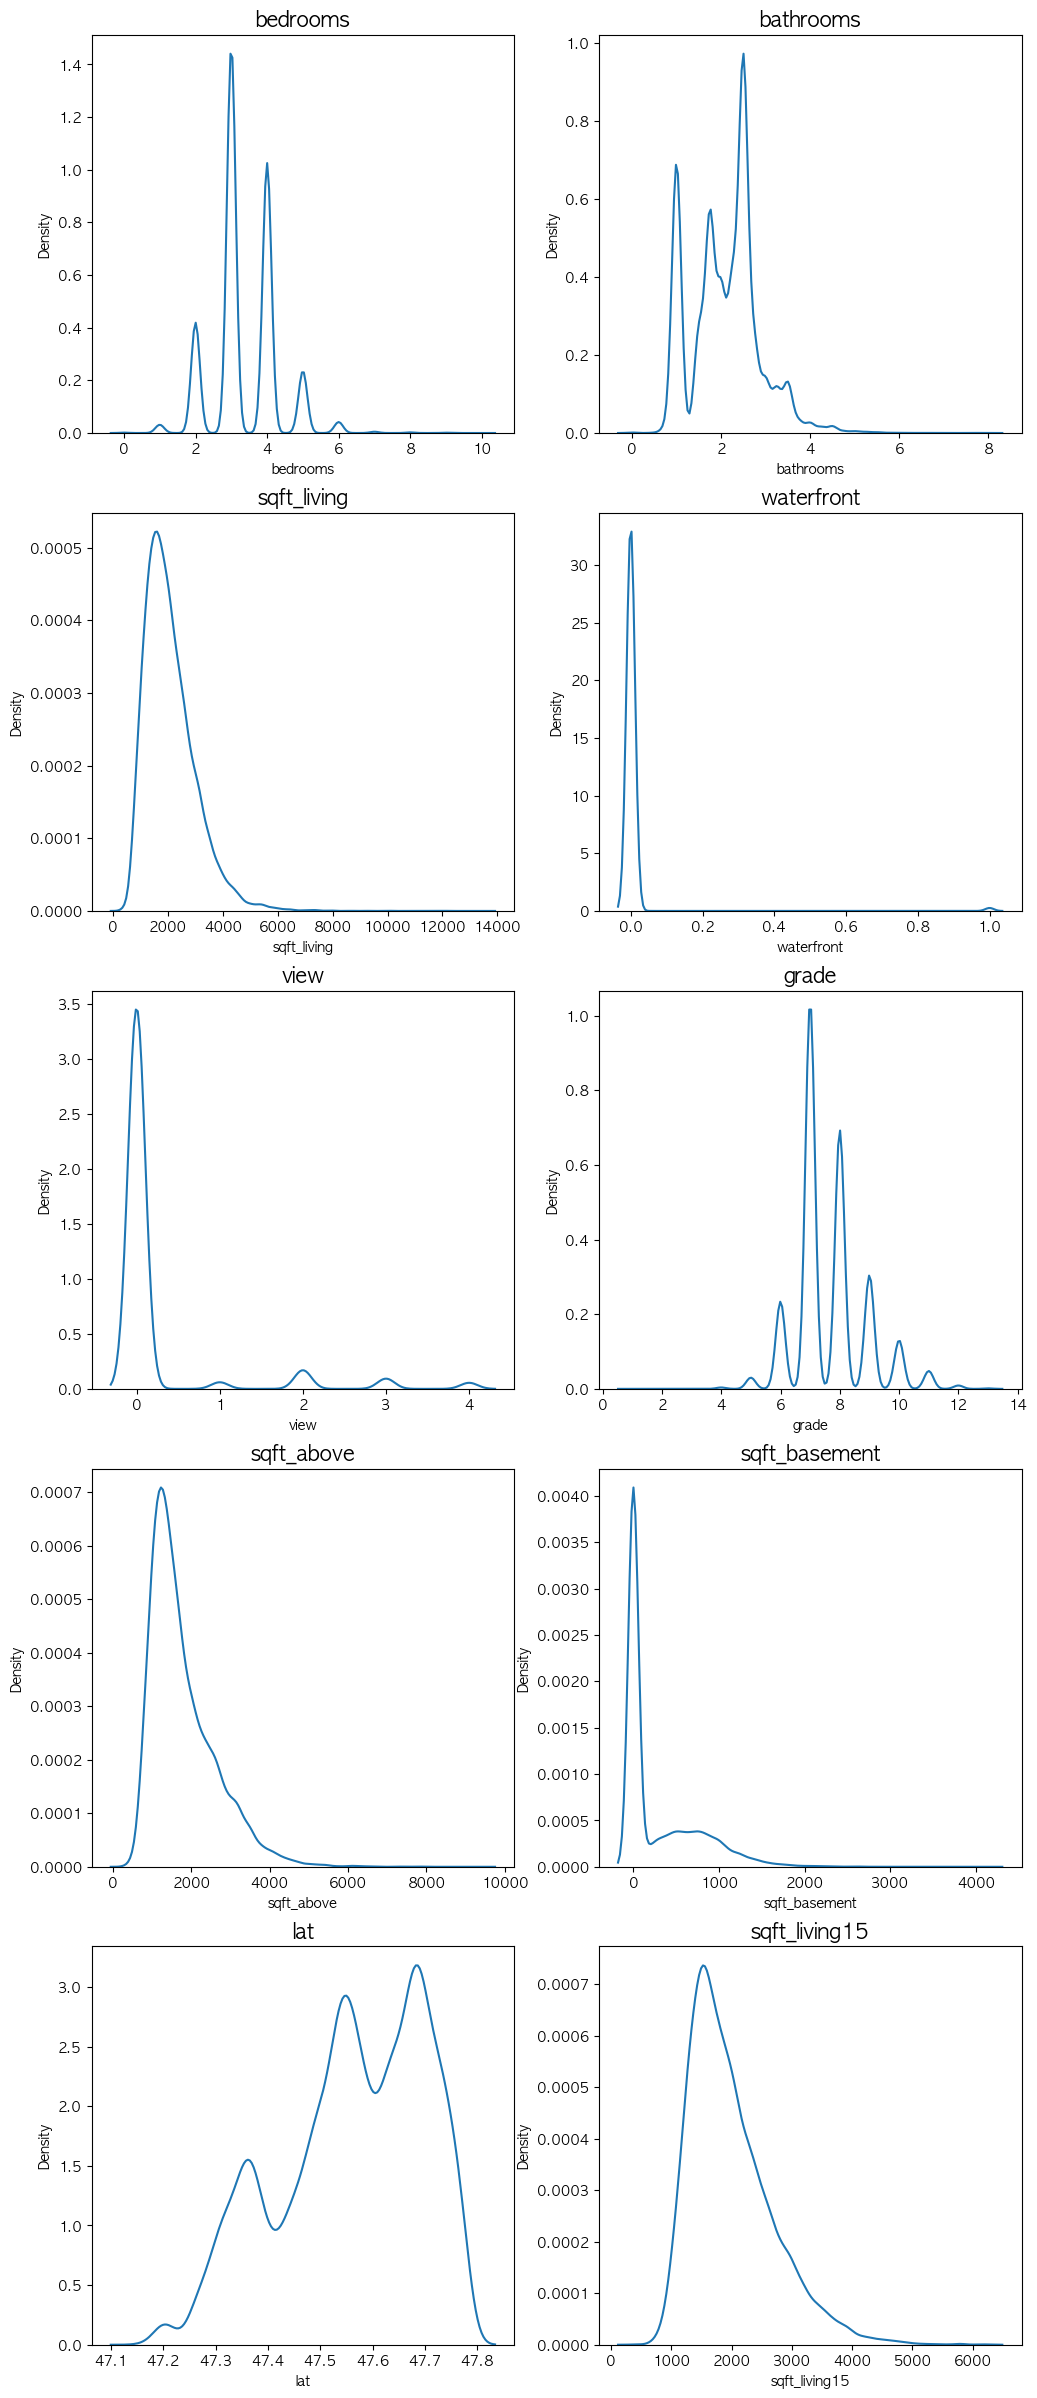

In [11]:
fig, ax = plt.subplots(5, 2, figsize=(12, 30)) 

count = 1                    # date 변수(count==0인 경우)는 제외
columns = data.columns
for row in range(5):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 11 :
            break

### (8) 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들기

numpy.log1p() 함수는 입력 배열의 각 요소에 대해 자연로그 log(1+x)을 반환해 주는 함수

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

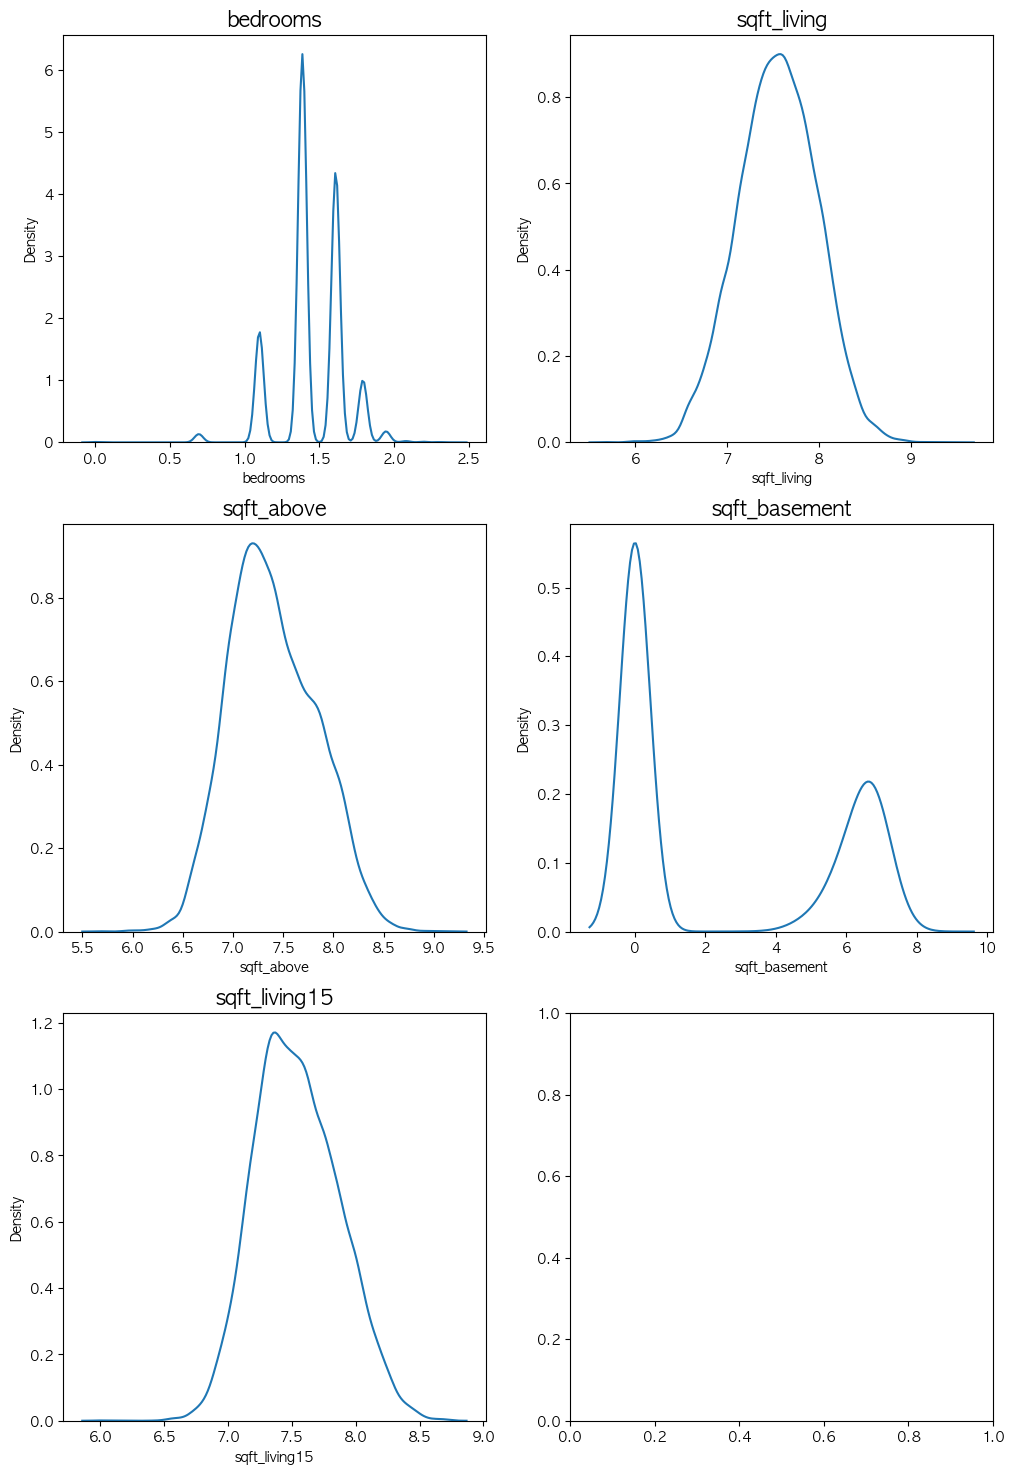

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(12, 18))

count = 0
for row in range(3):
    for col in range(2):
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
        if count == 5:
            break

### (9) y(=price) vs. y(=price)_log_transformation

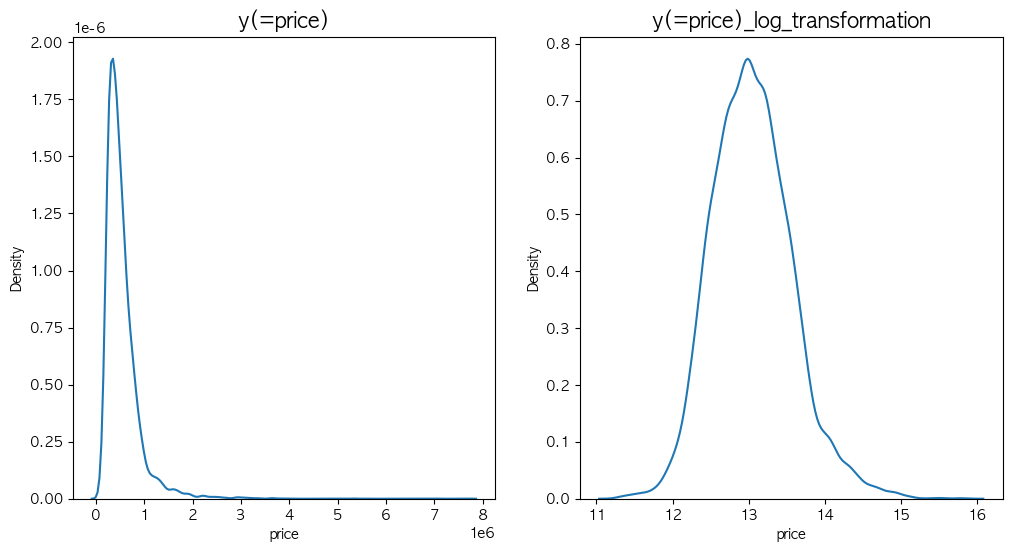

In [14]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
sns.kdeplot(y)
plt.title('y(=price)', fontsize = 15)

plt.subplot(122)
y_log_transformation = np.log1p(y)
sns.kdeplot(y_log_transformation)
plt.title('y(=price)_log_transformation', fontsize = 15)

plt.show()

# 2. 모델 설계 - Hyper Parameter Tuning

### (1) RMSE 계산

In [15]:
train = data.iloc[:train_data_len, :]
test = data.iloc[train_data_len:, :]

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
  
random_state=2022

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [17]:
# 네 가지의 모델에 대해 모두 RMSE값을 얻을 수 있도록
# get_scores(models, train_data, y) 함수로 만들어 보겠습니다. 

def get_scores(models, x, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=2022, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [20]:
param_grid = {'n_estimators': [50, 100], 'max_depth': [1, 10]}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,n_estimators,score,RMSLE
3,10,100,-2.703809e+10,164432.638520
2,10,50,-2.739145e+10,165503.614827
1,1,100,-3.870676e+10,196740.325257
0,1,50,-4.787553e+10,218804.781607


In [21]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([1475344.18907748,  298571.25036254,  917413.64124037, ...,
       1693739.71193385,  440824.94996551,  378864.46571834])

In [22]:
prediction = np.expm1(prediction)

### (2) 제출 과정을 함수로 만들기

In [23]:
def save_submission(model, train, y, test, model_name, rmsle=None) :
    model.fit(train_data, y)
    prediction = model.predict(test_data)
    prediction = np.expm1(prediction)
    submission = pd.read_csv('2019houseprice/sample_submission.csv')
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format('2019houseprice/sample_submission.csv', model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))